### Package

In [5]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

In [6]:
THICKNESS = (3.4, 6.7, 17.9, 40)
R_GOLD = 1.1

### Utility

In [7]:
def get_filtered_data(data_path, data_range):
    """
    @param: 
    data_range: [y_min, y_max, z_min, z_max]
    """
    # data reader
    data = pd.read_csv(data_path, skiprows=9, sep='\s+', names=['y', 'z', 'Ez'])
    # data filtered by y and z range:
    data_filter = (data.y >= data_range[0]) & (data.y <= data_range[1]) & (data.z >= data_range[2]) & (data.z <= data_range[3])
    
    return data[data_filter].reset_index(drop=True)

def get_filter_range(r, d, r_margin=0.3, 
                     d_low_margin=0.2, d_high_margin=0.4):
    """
    @param:
    r: radius of sphere
    d: thickness of SiO2 layer
    r_margin: 
    d_low_margin:
    d_high_margin:
    """
    return (-r-r_margin, r+r_margin, d-d_low_margin, d+d_high_margin)

def data_path_constructor(d):
    """
    
    """
    return './Ez/es_Ez_'+str(d)+'_extreme_plot.txt'

def remove_circle(data, d, r=R_GOLD):
    """
    
    """
    
    points = np.transpose([data.y, data.z])
    values = data.Ez.values

    # grid data
    y_min, y_max = data.y.min(), data.y.max()
    z_min, z_max = data.z.min(), data.z.max()
    y0, z0 = 0.0, d+r
    grid_y0, grid_z0 = np.mgrid[y_min:y_max:3000j, z_min:z_max:600j]
        
    # use complex number to help setup the grid mask
    grid = grid_y0 + 1.j * grid_z0
    center = y0 + 1.j * z0

    # Set inside the particle to NaN to remove the particle
    grid_mask = np.less_equal(abs(grid-center), r)
    grid[grid_mask] = np.nan
    grid_y1, grid_z1 = grid.real, grid.imag
        
    grid_data = griddata(points, values, (grid_y1, grid_z1), method='linear')
    
    return grid_data


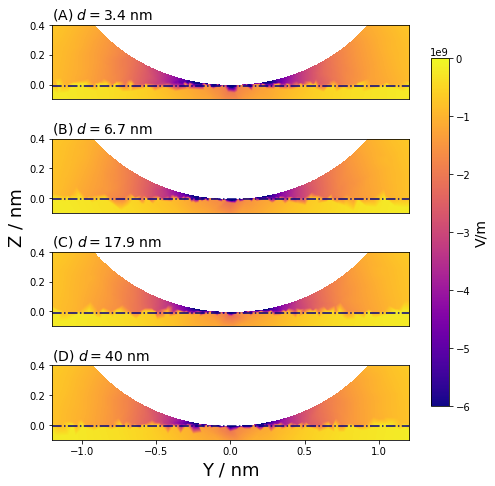

In [9]:
fig, axes = plt.subplots(nrows=4, figsize=(8, 8))

for i, d in enumerate(THICKNESS):
    
    data_path = data_path_constructor(d)
    data_range = get_filter_range(r=R_GOLD, d=d)
    data = get_filtered_data(data_path, data_range)
    data_grid = remove_circle(data, d)

    im = axes[i].imshow(np.transpose(data_grid), cmap='plasma', interpolation='bilinear', origin='lower', 
                        extent=[-1.5, 1.5, -0.2, 0.4], vmin=-6e9, vmax=-0)
    axes[i].axhline(-0.007, color='navy', linewidth=1.5, linestyle='-.')
    axes[i].get_xaxis().set_visible(False)
    # axes[i].get_yaxis().set_visible(True)
    axes[i].set_xlim([-1.2, 1.2])
    axes[i].set_ylim([-0.1, 0.4])
    axes[i].set_title('('+chr(i+65)+') $\mathit{ d} = $'+str(d)+' nm', loc='left', fontsize=14)
    # axes[i].add_artist(plt.Circle((0.0, 1.1), 1.1, color='navy', fill=False))

axes[3].get_xaxis().set_visible(True)
axes[3].set_xlabel('Y / nm', fontsize=18)
plt.text(-1.5, 1.5, 'Z / nm', size=18, rotation=90)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
cbar.set_label('V/m', fontsize=14)
fig.savefig('Ez_V1.png', dpi=600)